In [5]:
################################ config #################################

#!/usr/bin/env python3

from datetime import datetime
from astropy.io import fits
import numpy as np
import glob
import tqdm
import cupy as cp
import cuml
#from progressbar import progressbar

# parameters

stride = 4
win_size_large = 16
win_size_small = 4
clusters = 3

  0%|          | 0/8 [00:00<?, ?it/s]/ufs/andong/anaconda3/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
 12%|█▎        | 1/8 [00:00<00:00,  8.00it/s]

shape of data (8, 360, 720, 3)


100%|██████████| 8/8 [00:00<00:00, 11.40it/s]


(8, 360, 720)


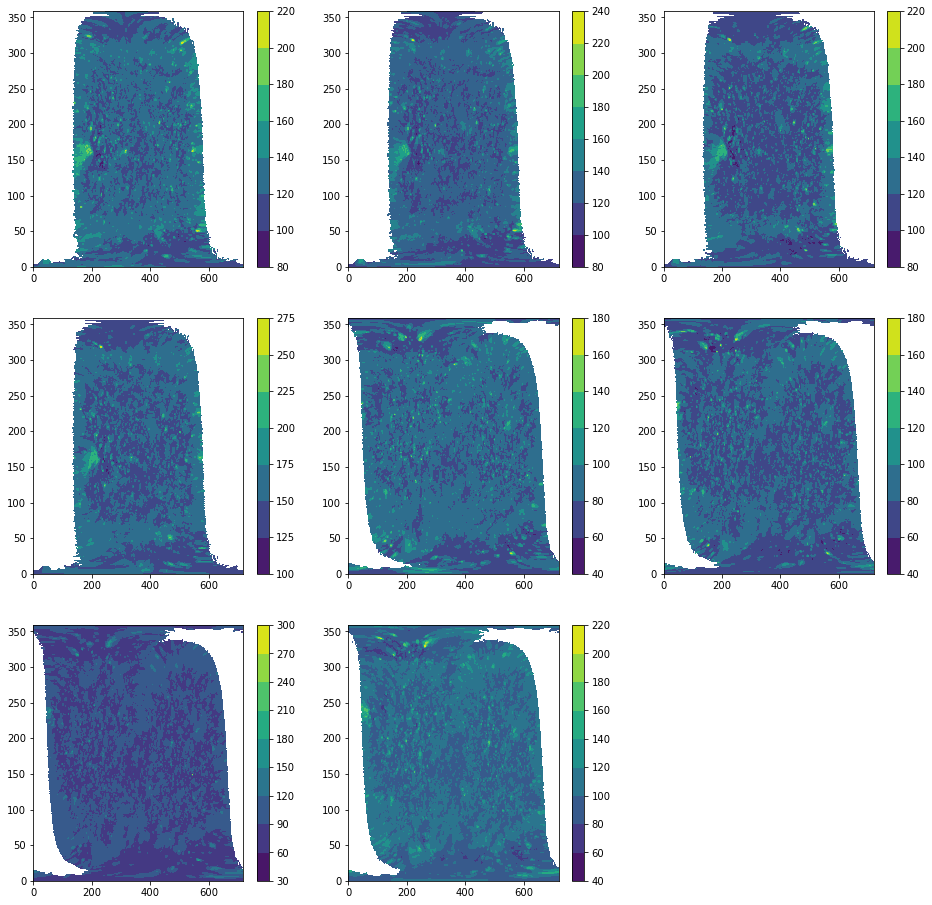

In [6]:
################################ read data file #################################
import matplotlib.pyplot as plt

data = np.load('example/sample_synchronic_maps.npy')

print('shape of data', data.shape)

all_data = np.zeros([data.shape[0], data.shape[1], data.shape[2]])

p = tqdm.tqdm

plt.figure(figsize=(16,16))
for i in p(range(data.shape[0])):

    plt.subplot(3, 3, i+1)
    all_data[i] = np.nanmean(data[i], axis=2)
    plt.contourf(all_data[i])
    plt.colorbar()
    
print(all_data.shape)


In [65]:
################################ dimensional reduction prep (e.g., remove nan) #################################

import skimage.measure

clu = []
coord = []

idx_image = 0

for m in p(range(win_size_large, all_data.shape[1]-win_size_large, stride)):
    for n in range(win_size_large+200, 
                   all_data.shape[2]-win_size_large-120, 
                   stride):
        '''
        t = norm_ah(
            all_data[i, 
                     m-win_size_large:m+win_size_large, 
                     n-win_size_large:n+win_size_large]**2)
        '''
        t = all_data[idx_image, 
                     m-win_size_large:m+win_size_large, 
                     n-win_size_large:n+win_size_large]
        coord_t = [m, n]
        
        t1 = skimage.measure.block_reduce(
                t, 
                (win_size_small, win_size_small), 
                np.nanmean).reshape(-1,1)
        
        where_are_NaNs = np.isnan(t1)
        t1[where_are_NaNs] = -99
        
        clu.append(t1.squeeze())
        coord.append(coord_t)
    
print(np.array(clu).shape)
X = np.array(clu)
coords = np.array(coord)


  0%|          | 0/82 [00:00<?, ?it/s]/ufs/andong/anaconda3/envs/rapids/lib/python3.7/site-packages/skimage/measure/block.py:87: RuntimeWarning: Mean of empty slice
  **func_kwargs)
100%|██████████| 82/82 [00:00<00:00, 84.90it/s]

(7544, 64)


sklearn PCA: 0.016594886779785156
cuml PCA: 0.013787031173706055
(7544, 20)


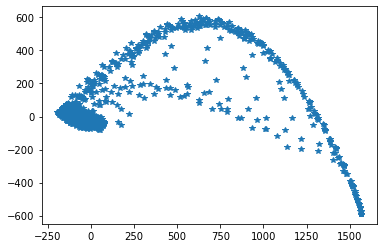

In [66]:
################################ dimensional reduction (PCA) #################################

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from cuml.decomposition import PCA as cuPCA
from time import time

sta = time()
X_t = PCA(n_components=20).fit_transform(X)
mid = time()

X_t = PCA(n_components=20).fit_transform(X)
end = time()

print('sklearn PCA:', mid-sta)
print('cuml PCA:', end-mid)
print(X_t.shape)
plt.plot(X_t[:,0], X_t[:,1], '*')
plt.show()

(7544, 2)


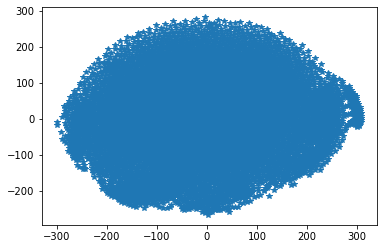

In [48]:
################################ dimensional reduction (T-SNE) #################################

# better not to run it, very time consuming
#from sklearn.manifold import TSNE
from cuml import TSNE as cuTSNE

X_t = cuTSNE(n_components=2).fit_transform(X)

print(X_t.shape)
plt.plot(X_t[:,0], X_t[:,1], '*')

[0 0 0 ... 0 0 0]


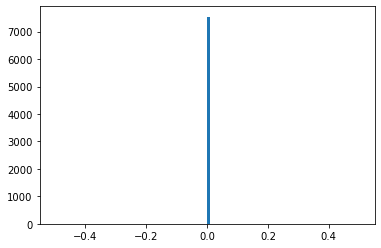

In [49]:
###################################### clustering (DBSCAN) ##########################
from sklearn.cluster import DBSCAN
from cuml.cluster import DBSCAN as cuDBSCAN

# Compute DBSCAN
db = cuDBSCAN(eps=20, min_samples=5).fit(X_t)

labels = db.labels_        
    
plt.hist(labels, 100)
print(labels)

sklearn Kmeans: 0.9861001968383789
cuml Kmeans: 0.015125036239624023


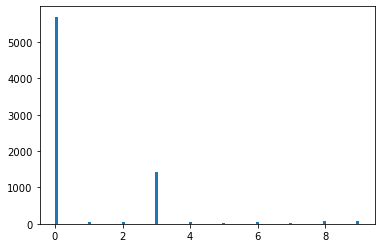

In [69]:
###################################### clustering (Kmeans) ##########################

from sklearn.cluster import KMeans
from cuml import KMeans as cuKMeans

sta = time()

kmeans = KMeans(n_clusters=10).fit(X_t)
labels = kmeans.predict(X_t)
mid = time()

cukmeans = cuKMeans(n_clusters=10).fit(X_t)
culabels = cukmeans.predict(X_t)
end = time()

plt.hist(labels, 100)

print('sklearn Kmeans:', mid-sta)
print('cuml Kmeans:', end-mid)



(8, 360, 720)


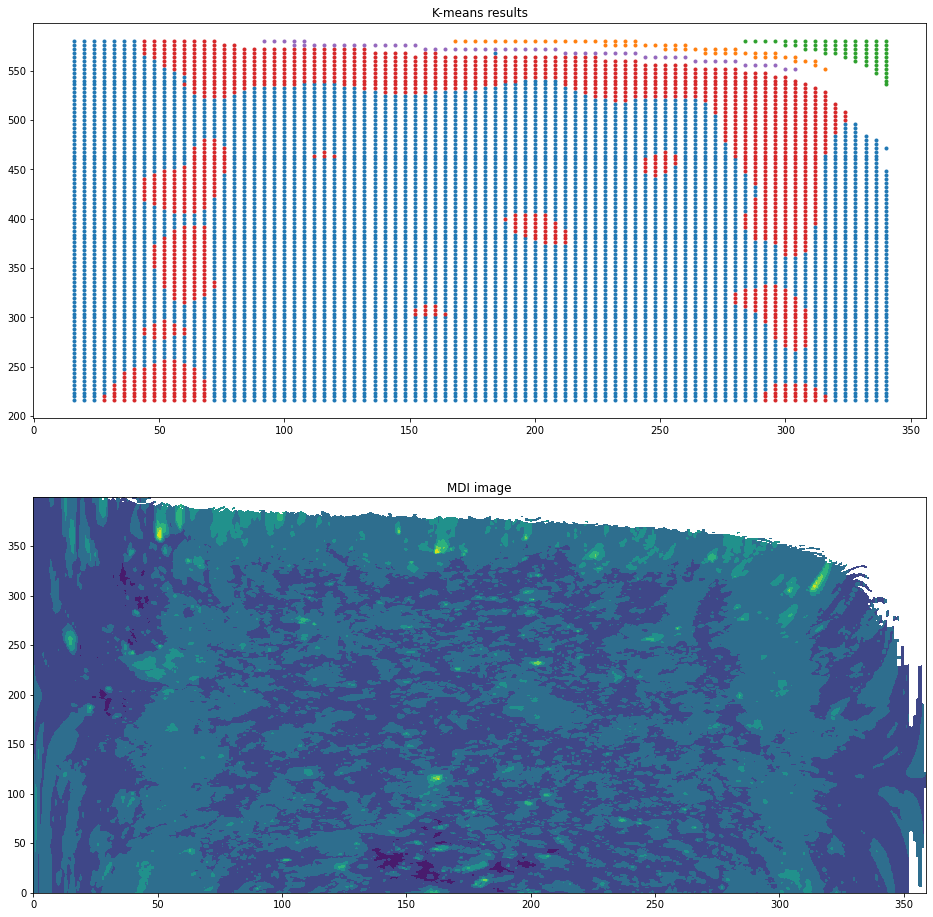

In [70]:
###################################### display ##########################

#%matplotlib notebook
plt.figure(figsize=(16, 16))
plt.subplot(2,1,1)
for i in np.arange(5):
    idx = np.where(labels==i)[0]
    plt.plot(coords[idx, 0], coords[idx, 1], '.')
    
plt.title('K-means results')
plt.subplot(2,1,2)
print(all_data.shape)
plt.contourf(all_data[0, :, 200:600].T)
plt.title('MDI image')

plt.savefig('comparison.eps', dpi=300)

plt.show()
